In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
import seaborn as sns
from hyperopt import hp
import sklearn
from hyperopt.pyll import scope
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, matthews_corrcoef, make_scorer, confusion_matrix, precision_score, recall_score, f1_score
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.pipeline import make_pipeline, Pipeline
from time import time
from tqdm import tqdm
from sklearn.ensemble import BaggingClassifier
import os, pickle
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
from collections import Counter
import pickle

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

,gvkey,datadate,conm,at,cogs,csho,dvp,ebit,gp,ib,...,xido,xopr,mkvalt,sic,bankrupt,Altman_X1,Altman_X2,Altman_X3,Altman_X4,Altman_X5
0,1240,2002-01-31,ALBERTSON'S INC,15967.000,26094.000,407.000,0.0,1787.000,11837.000,501.000,...,0.000,35118.000,11701.2500,5411.0,0,0.064320,0.339074,0.111918,1.164072,2.375587
1,1655,2002-01-31,ANGELICA CORP,290.865,246.466,8.608,0.0,12.856,103.597,1.629,...,-24.338,326.107,101.5744,7200.0,0,0.161449,0.488845,0.044199,0.680060,1.203524
2,1864,2002-01-31,REX AMERICAN RESOURCES CORP,307.329,325.912,8.163,0.0,22.236,138.591,22.554,...,-0.245,438.069,240.4004,2860.0,0,0.300186,0.438319,0.072352,1.508575,1.511419
3,1878,2002-01-31,AUTODESK INC,902.444,124.903,55.644,0.0,131.804,822.588,90.313,...,0.000,768.484,2281.4040,7370.0,0,0.214106,0.079664,0.146052,6.114234,1.049917
4,2436,2002-01-31,CALERES INC,700.898,1044.110,17.484,0.0,54.842,711.738,0.949,...,-4.911,1674.299,278.6950,3140.0,0,0.321669,0.206953,0.078245,0.627350,2.505141


In [3]:
### Get Altman's Z-score and add it to the dataframes
train_df['Altman_z'] = train_df['Altman_X1'] + train_df['Altman_X2'] + train_df['Altman_X3'] + train_df['Altman_X4'] + train_df['Altman_X5']
test_df['Altman_z'] = test_df['Altman_X1'] + test_df['Altman_X2'] + test_df['Altman_X3'] + test_df['Altman_X4'] + test_df['Altman_X5']



# Visualize the Data & Run Preliminary EDA

In [4]:
train_df["bankrupt"].value_counts()

0    26638
1      181
Name: bankrupt, dtype: int64

Text(0.5, 1.0, 'Altman_Z Distribution by SIC code')

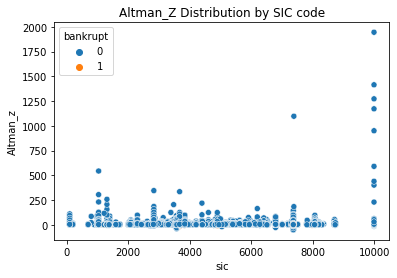

In [5]:
## Visualize Altman-Z against SIC to see if there are industries with more bankruptcy
sns.scatterplot(x="sic", y="Altman_z", hue="bankrupt", data=train_df)
plt.title("Altman_Z Distribution by SIC code")

Text(0.5, 1.0, 'Altman_Z Distribution by bankrupt 1/0')

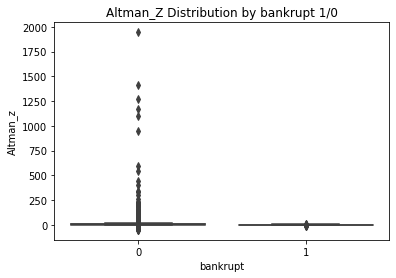

In [6]:
## Is there different Altman_Z distributions for bankrupt/ non-bankrupt?
sns.boxplot(x = "bankrupt", y = "Altman_z", data = train_df)
plt.title("Altman_Z Distribution by bankrupt 1/0")

In [7]:
train_df[train_df["bankrupt"] == 0]["Altman_z"].describe()

count    26638.000000
mean         6.554128
std         23.393720
min        -51.650597
25%          2.074084
50%          3.677779
75%          6.703316
max       1945.426953
Name: Altman_z, dtype: float64

In [8]:
train_df[train_df["bankrupt"] == 1]["Altman_z"].describe()

count    181.000000
mean       0.565069
std        2.278507
min      -14.412592
25%       -0.278407
50%        0.773593
75%        1.806555
max        5.103282
Name: Altman_z, dtype: float64

In [9]:
train_df.describe()

,gvkey,at,cogs,csho,dvp,ebit,gp,ib,lct,lt,...,xopr,mkvalt,sic,bankrupt,Altman_X1,Altman_X2,Altman_X3,Altman_X4,Altman_X5,Altman_z
count,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,...,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000
mean,60866.387785,3915.880813,2296.434405,142.212575,1.088146,370.051918,1079.752864,182.198410,858.276254,2353.328278,...,2842.903636,4214.319994,4539.654983,0.006749,0.228964,-0.093309,0.063872,5.280239,1.033943,6.513708
std,62597.875446,13419.380779,10071.695546,448.690088,11.656380,1648.483456,4097.193898,1216.434534,3287.416097,8189.983320,...,11627.511520,16416.532733,2030.029301,0.081876,0.238151,1.366170,0.128516,23.276809,0.845404,23.320545
min,1004.000000,100.002000,-0.206000,0.001000,-1013.000000,-8851.000000,-6887.000000,-44574.000000,0.000000,0.070000,...,-43.906000,0.001300,100.000000,0.000000,-4.756474,-55.591206,-2.218093,0.000008,-0.000020,-51.650597
25%,9465.000000,253.010000,109.694500,22.900500,0.000000,8.674000,74.797000,-2.570500,48.569500,94.391000,...,183.701000,247.257800,3087.500000,0.000000,0.057624,-0.127166,0.026217,0.900691,0.491820,2.051453
50%,28338.000000,665.297000,350.991000,44.283000,0.000000,47.547000,202.931000,21.507000,128.394000,323.232000,...,494.496000,695.709200,3842.000000,0.000000,0.200202,0.128093,0.073382,2.062394,0.842522,3.654174
75%,121659.000000,2266.698000,1240.225500,99.537000,0.000000,193.036000,643.293500,98.517000,443.099000,1272.518500,...,1629.707000,2250.829250,5812.000000,0.000000,0.374881,0.348341,0.121601,5.004862,1.343228,6.662777
max,297209.000000,331052.000000,346775.000000,10862.000000,340.000000,66290.000000,112370.000000,45220.000000,105501.634000,204822.718000,...,388666.000000,504239.580000,9997.000000,1.000000,0.999369,2.044237,1.271060,1945.385714,25.397335,1945.426953


### Insights from EDA

From the above EDA, it is clear that there are some SIC's which exhibit higher bankruptcy rates. The statistical distribution of Altman's Z-score is also very different for companies which went bankrupt, versus those that didn't.
Digging deeper, the mean Altman's z-score for bankrupt=1 is 0.565, and the median is 0.773, whereas for bankrupt=0, the mean and median are 6.554 and 3.678 respectively - clearly, Altman's is a decent guage of predicting bankruptcy.
However, I foresee that there will be many false positives just by using Altman's Z-score, since there are many good companies (bankrupt=0) with a low score - as can be seen by the 25th percentile at 2.07, which is below our threshold cutoff of 2.675.

# Question 1
Please apply Altman’s Z-score with a cut-off value at 2.675 for classification.

In [10]:
actual = train_df["bankrupt"]
pred = list(map(lambda x: 1 if x<=2.765 else 0, train_df["Altman_z"], ))

In [11]:
cm = confusion_matrix(actual, pred)
TN, FP, FN, TP = cm.ravel()
print("Confusion Matrix: \n", cm)
print("True negative: %s, False positive: %s, False negative: %s, True positive: %s" %(TN, FP, FN, TP))

Confusion Matrix: 
 [[16946  9692]
 [   21   160]]
True negative: 16946, False positive: 9692, False negative: 21, True positive: 160


In [12]:
print("Accuracy: ", accuracy_score(actual, pred))
print("Recall: ", recall_score(actual, pred))
print("Precision: ", precision_score(actual, pred))
from sklearn.metrics import matthews_corrcoef
print("MCC: ", matthews_corrcoef(actual, pred))
print("F1: ", f1_score(actual, pred))

Accuracy:  0.6378313881949365
Recall:  0.8839779005524862
Precision:  0.016240357287860333
MCC:  0.08833705585350643
F1:  0.03189474733379846


# Question 2
Please train and build a prediction model by Logistic regression, CART (DecisionTreeClassifier), and XGBoost (with XGBoost random_state=1). The input features are the 5 financial ratios in Q1. [5-fold cv with shuffle=False]

In [13]:
train_df.head()

,gvkey,datadate,conm,at,cogs,csho,dvp,ebit,gp,ib,...,xopr,mkvalt,sic,bankrupt,Altman_X1,Altman_X2,Altman_X3,Altman_X4,Altman_X5,Altman_z
0,1240,2002-01-31,ALBERTSON'S INC,15967.000,26094.000,407.000,0.0,1787.000,11837.000,501.000,...,35118.000,11701.2500,5411.0,0,0.064320,0.339074,0.111918,1.164072,2.375587,4.054972
1,1655,2002-01-31,ANGELICA CORP,290.865,246.466,8.608,0.0,12.856,103.597,1.629,...,326.107,101.5744,7200.0,0,0.161449,0.488845,0.044199,0.680060,1.203524,2.578078
2,1864,2002-01-31,REX AMERICAN RESOURCES CORP,307.329,325.912,8.163,0.0,22.236,138.591,22.554,...,438.069,240.4004,2860.0,0,0.300186,0.438319,0.072352,1.508575,1.511419,3.830851
3,1878,2002-01-31,AUTODESK INC,902.444,124.903,55.644,0.0,131.804,822.588,90.313,...,768.484,2281.4040,7370.0,0,0.214106,0.079664,0.146052,6.114234,1.049917,7.603973
4,2436,2002-01-31,CALERES INC,700.898,1044.110,17.484,0.0,54.842,711.738,0.949,...,1674.299,278.6950,3140.0,0,0.321669,0.206953,0.078245,0.627350,2.505141,3.739357


### XGBoost Model

In [14]:
x_var = ["Altman_X1", "Altman_X2", "Altman_X3", "Altman_X4", "Altman_X5"]
y_var = "bankrupt"

q2_df = train_df[x_var]
y_actual = train_df[y_var]
q2_df.head()

,Altman_X1,Altman_X2,Altman_X3,Altman_X4,Altman_X5
0,0.064320,0.339074,0.111918,1.164072,2.375587
1,0.161449,0.488845,0.044199,0.680060,1.203524
2,0.300186,0.438319,0.072352,1.508575,1.511419
3,0.214106,0.079664,0.146052,6.114234,1.049917
4,0.321669,0.206953,0.078245,0.627350,2.505141


In [15]:
auc_scores, all_y_preds, all_y_proba, all_y_true= [], [], [], []

kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=False)
kf.get_n_splits(q2_df, y_actual)

for train_index, test_index in kf.split(train_df[x_var], train_df[y_var]):
    curr_train, curr_test = train_df.iloc[train_index], train_df.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    XG = XGBClassifier(random_state =1)
    XG.fit(X_train, y_train)
    y_preds = XG.predict(X_test)
    y_proba = XG.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

C:\Users\ksjag\anaconda3\envs\pyportfolioopt\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [16]:
print("accuracy:", accuracy_score(all_y_true, all_y_preds))

print("precision:", precision_score(all_y_true, all_y_preds))
print("recall:", recall_score(all_y_true, all_y_preds))
print("MCC:", matthews_corrcoef(all_y_true, all_y_preds))
print("F1:", f1_score(all_y_true, all_y_preds))

confusion_matrix(all_y_true, all_y_preds)

accuracy: 0.9925053133972184
precision: 0.2222222222222222
recall: 0.04419889502762431
MCC: 0.09648671909706168
F1: 0.07373271889400922


array([[26610,    28],
       [  173,     8]], dtype=int64)

### CART (Decision Tree) Model

In [17]:
auc_scores, all_y_preds, all_y_proba, all_y_true= [], [], [], []

kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=False)
kf.get_n_splits(q2_df, y_actual)

for train_index, test_index in kf.split(train_df[x_var], train_df[y_var]):
    curr_train, curr_test = train_df.iloc[train_index], train_df.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    CART = DecisionTreeClassifier(random_state=1)
    cart_model = CART.fit(X_train, y_train)
    y_preds = cart_model.predict(X_test)
    y_proba = cart_model.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

C:\Users\ksjag\anaconda3\envs\pyportfolioopt\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [18]:
print("accuracy:", accuracy_score(all_y_true, all_y_preds))

print("precision:", precision_score(all_y_true, all_y_preds))
print("recall:", recall_score(all_y_true, all_y_preds))
print("MCC:", matthews_corrcoef(all_y_true, all_y_preds))
print("F1:", f1_score(all_y_true, all_y_preds))

confusion_matrix(all_y_true, all_y_preds)

accuracy: 0.9876207166561021
precision: 0.12437810945273632
recall: 0.13812154696132597
MCC: 0.12484691347193112
F1: 0.13089005235602091


array([[26462,   176],
       [  156,    25]], dtype=int64)

### Logistic Regression

In [19]:
auc_scores, all_y_preds, all_y_proba, all_y_true= [], [], [], []

kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=False)
kf.get_n_splits(q2_df, y_actual)

for train_index, test_index in kf.split(train_df[x_var], train_df[y_var]):
    curr_train, curr_test = train_df.iloc[train_index], train_df.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    lr = LogisticRegression(random_state=1)
    lr_model = lr.fit(X_train, y_train)
    y_preds = lr_model.predict(X_test)
    y_proba = lr_model.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

C:\Users\ksjag\anaconda3\envs\pyportfolioopt\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [20]:
print("accuracy:", accuracy_score(all_y_true, all_y_preds))

print("precision:", precision_score(all_y_true, all_y_preds))
print("recall:", recall_score(all_y_true, all_y_preds))
print("MCC:", matthews_corrcoef(all_y_true, all_y_preds))
print("F1:", f1_score(all_y_true, all_y_preds))

confusion_matrix(all_y_true, all_y_preds)

accuracy: 0.9932510533576941
precision: 0.5
recall: 0.04419889502762431
MCC: 0.14719355521340557
F1: 0.08121827411167512


array([[26630,     8],
       [  173,     8]], dtype=int64)

# Question 3
Train only CART Decision Tree with the settings you used in Q2 and try the following three methods. 
1. SMOTE for oversampling to target a 1:2 minority: majority ratio by setting sampling_strategy = 0.5  
2. SMOTE (1:2 ratio) + Edited NN (5-NN method) 
3. over-weighting rows with label=1 by 40 times (you should use class_weight variable in DecisionTreeClassifier to do this). 

In [21]:
x_var = ["Altman_X1", "Altman_X2", "Altman_X3", "Altman_X4", "Altman_X5"]
y_var = "bankrupt"

In [22]:
# smote_only = SMOTE(random_state=1, sampling_strategy=0.5)
# X_res_smote, y_res_smote = smote_only.fit_resample(X_train, y_train)
# print(f'Resampled dataset shape {Counter(y_res_smote)}')

# ennObj = EditedNearestNeighbours(n_neighbors=3)
# smote_enn = SMOTEENN(smote=smote_only , enn= ennObj)
# X_res_smoteENN, y_res_smoteENN = smote_enn.fit_resample(X_train, y_train)
# print(f'Resampled dataset shape {Counter(y_res_smoteENN)}')

### SMOTE Only

In [23]:
auc_scores, all_y_preds, all_y_proba, all_y_true= [], [], [], []

kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=False)
kf.get_n_splits(q2_df, y_actual)

for train_index, test_index in kf.split(train_df[x_var], train_df[y_var]):
    curr_train, curr_test = train_df.iloc[train_index], train_df.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    smote_only = SMOTE(random_state=1, sampling_strategy=0.5)
    X_res_smote, y_res_smote = smote_only.fit_resample(X_train, y_train)
    print(f'Resampled dataset shape {Counter(y_res_smote)}')
    
    CART = DecisionTreeClassifier(random_state=1)
    cart_model = CART.fit(X_res_smote, y_res_smote)
    y_preds = cart_model.predict(X_test)
    y_proba = cart_model.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

C:\Users\ksjag\anaconda3\envs\pyportfolioopt\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Resampled dataset shape Counter({0: 21310, 1: 10655})
Resampled dataset shape Counter({0: 21310, 1: 10655})
Resampled dataset shape Counter({0: 21310, 1: 10655})
Resampled dataset shape Counter({0: 21311, 1: 10655})
Resampled dataset shape Counter({0: 21311, 1: 10655})


In [24]:
print("accuracy:", accuracy_score(all_y_true, all_y_preds))

print("precision:", precision_score(all_y_true, all_y_preds))
print("recall:", recall_score(all_y_true, all_y_preds))
print("MCC:", matthews_corrcoef(all_y_true, all_y_preds))
print("F1:", f1_score(all_y_true, all_y_preds))

confusion_matrix(all_y_true, all_y_preds)

accuracy: 0.9626384279801633
precision: 0.06002143622722401
recall: 0.30939226519337015
MCC: 0.1235275497999906
F1: 0.10053859964093356


array([[25761,   877],
       [  125,    56]], dtype=int64)

### SMOTE + ENN

In [25]:
auc_scores, all_y_preds, all_y_proba, all_y_true= [], [], [], []

kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=False)
kf.get_n_splits(q2_df, y_actual)

for train_index, test_index in kf.split(train_df[x_var], train_df[y_var]):
    curr_train, curr_test = train_df.iloc[train_index], train_df.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    ennObj = EditedNearestNeighbours(n_neighbors=5)
    smote_enn = SMOTEENN(smote=smote_only , enn= ennObj)
    X_res_smoteENN, y_res_smoteENN = smote_enn.fit_resample(X_train, y_train)
    print(f'Resampled dataset shape {Counter(y_res_smoteENN)}')
    
    CART = DecisionTreeClassifier(random_state=1)
    cart_model = CART.fit(X_res_smoteENN, y_res_smoteENN)
    y_preds = cart_model.predict(X_test)
    y_proba = cart_model.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

C:\Users\ksjag\anaconda3\envs\pyportfolioopt\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Resampled dataset shape Counter({0: 19625, 1: 10655})
Resampled dataset shape Counter({0: 19381, 1: 10655})
Resampled dataset shape Counter({0: 19631, 1: 10655})
Resampled dataset shape Counter({0: 19426, 1: 10655})
Resampled dataset shape Counter({0: 19462, 1: 10655})


In [26]:
print("accuracy:", accuracy_score(all_y_true, all_y_preds))

print("precision:", precision_score(all_y_true, all_y_preds))
print("recall:", recall_score(all_y_true, all_y_preds))
print("MCC:", matthews_corrcoef(all_y_true, all_y_preds))
print("F1:", f1_score(all_y_true, all_y_preds))

confusion_matrix(all_y_true, all_y_preds)

accuracy: 0.947499906782505
precision: 0.06209850107066381
recall: 0.48066298342541436
MCC: 0.1587139113759707
F1: 0.10998735777496839


array([[25324,  1314],
       [   94,    87]], dtype=int64)

### Overweighting Class=1

In [27]:
auc_scores, all_y_preds, all_y_proba, all_y_true= [], [], [], []

kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=False)
kf.get_n_splits(q2_df, y_actual)

for train_index, test_index in kf.split(train_df[x_var], train_df[y_var]):
    curr_train, curr_test = train_df.iloc[train_index], train_df.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    CART = DecisionTreeClassifier(random_state=1, class_weight={0:1, 1:40})
    cart_model = CART.fit(X_train, y_train)
    y_preds = cart_model.predict(X_test)
    y_proba = cart_model.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

C:\Users\ksjag\anaconda3\envs\pyportfolioopt\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [28]:
print("accuracy:", accuracy_score(all_y_true, all_y_preds))

print("precision:", precision_score(all_y_true, all_y_preds))
print("recall:", recall_score(all_y_true, all_y_preds))
print("MCC:", matthews_corrcoef(all_y_true, all_y_preds))
print("F1:", f1_score(all_y_true, all_y_preds))

confusion_matrix(all_y_true, all_y_preds)

accuracy: 0.988142734628435
precision: 0.14871794871794872
recall: 0.16022099447513813
MCC: 0.14839752868376088
F1: 0.15425531914893617


array([[26472,   166],
       [  152,    29]], dtype=int64)

# Question 4

In [29]:
## Re-read the 

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")


train_df['Altman_z'] = train_df['Altman_X1'] + train_df['Altman_X2'] + train_df['Altman_X3'] + train_df['Altman_X4'] + train_df['Altman_X5']
test_df['Altman_z'] = test_df['Altman_X1'] + test_df['Altman_X2'] + test_df['Altman_X3'] + test_df['Altman_X4'] + test_df['Altman_X5']

### Do one-hot-encoding for SIC

In [30]:
## Select Relevant features, and apply one-hot encoding on SIC for train_df and test_df

train_df["sic_class"] = train_df["sic"].apply(lambda x: str(x))
train_df["sic_class"] = train_df["sic_class"].apply(lambda x: '0'+x if len(x)!=6 else x)
train_df["sic_class"] = train_df["sic_class"].apply(lambda x: x[0])
train_df.head()

,gvkey,datadate,conm,at,cogs,csho,dvp,ebit,gp,ib,...,mkvalt,sic,bankrupt,Altman_X1,Altman_X2,Altman_X3,Altman_X4,Altman_X5,Altman_z,sic_class
0,1240,2002-01-31,ALBERTSON'S INC,15967.000,26094.000,407.000,0.0,1787.000,11837.000,501.000,...,11701.2500,5411.0,0,0.064320,0.339074,0.111918,1.164072,2.375587,4.054972,5
1,1655,2002-01-31,ANGELICA CORP,290.865,246.466,8.608,0.0,12.856,103.597,1.629,...,101.5744,7200.0,0,0.161449,0.488845,0.044199,0.680060,1.203524,2.578078,7
2,1864,2002-01-31,REX AMERICAN RESOURCES CORP,307.329,325.912,8.163,0.0,22.236,138.591,22.554,...,240.4004,2860.0,0,0.300186,0.438319,0.072352,1.508575,1.511419,3.830851,2
3,1878,2002-01-31,AUTODESK INC,902.444,124.903,55.644,0.0,131.804,822.588,90.313,...,2281.4040,7370.0,0,0.214106,0.079664,0.146052,6.114234,1.049917,7.603973,7
4,2436,2002-01-31,CALERES INC,700.898,1044.110,17.484,0.0,54.842,711.738,0.949,...,278.6950,3140.0,0,0.321669,0.206953,0.078245,0.627350,2.505141,3.739357,3


In [31]:
# ### Check if 0s have been properly classified - there need to be some 'true' values in this series
# for i in train_df["sic_class"]:
#     print(i == '0')
#     #if i=="0": print(i)

In [32]:
test_df["sic_class"] = test_df["sic"].apply(lambda x: str(x))
test_df["sic_class"] = test_df["sic_class"].apply(lambda x: '0'+x if len(x)!=4 else x)
test_df["sic_class"] = test_df["sic_class"].apply(lambda x: x[0])
test_df.head()

,id,at,cogs,csho,dvp,ebit,gp,ib,lct,lt,...,mkvalt,sic,Altman_X1,Altman_X2,Altman_X3,Altman_X4,Altman_X5,bankrupt,Altman_z,sic_class
0,0,438.049,364.536,8.330,0.0,23.460,45.416,26.495,37.241,156.206,...,214.0810,2860,0.204995,0.740381,0.053556,1.370504,0.935859,NaN,3.305295,2
1,1,3227.800,113.600,225.900,0.0,354.300,2102.000,285.300,954.100,1344.900,...,8132.4000,7370,0.291778,0.160326,0.109765,6.046844,0.686412,NaN,7.295124,7
2,2,1227.476,1520.884,41.971,0.0,65.410,1061.940,8.923,524.580,813.760,...,396.6260,3140,0.236712,0.241455,0.053288,0.487399,2.104175,NaN,3.123029,3
3,3,394.559,358.532,11.088,0.0,82.269,177.235,63.046,56.518,83.832,...,630.0202,3537,0.394286,0.739892,0.208509,7.515271,1.357888,NaN,10.215846,3
4,4,551.089,574.176,29.163,0.0,96.475,357.282,64.834,156.993,184.410,...,781.8600,5621,0.493820,0.532903,0.175062,4.239792,1.690213,NaN,7.131791,5


In [33]:
# ### Check if 0s have been properly classified - there need to be some 'true' values in this series
# for i in test_df["sic_class"]:
#     print(i == '0')
#     #if i=="0": print(i)

In [34]:
### Convert into int type
train_df["sic_class"] = train_df["sic_class"].apply(lambda x: int(x))
test_df["sic_class"] = test_df["sic_class"].apply(lambda x: int(x))

In [35]:
### One-hot-encode the sic_class
sic_dummy_train = pd.get_dummies(train_df["sic_class"], prefix="sic")
sic_dummy_test = pd.get_dummies(test_df["sic_class"], prefix="sic")

train_df = train_df.join([sic_dummy_train])
test_df = test_df.join([sic_dummy_test])
train_df.head()

,gvkey,datadate,conm,at,cogs,csho,dvp,ebit,gp,ib,...,sic_0,sic_1,sic_2,sic_3,sic_4,sic_5,sic_6,sic_7,sic_8,sic_9
0,1240,2002-01-31,ALBERTSON'S INC,15967.000,26094.000,407.000,0.0,1787.000,11837.000,501.000,...,0,0,0,0,0,1,0,0,0,0
1,1655,2002-01-31,ANGELICA CORP,290.865,246.466,8.608,0.0,12.856,103.597,1.629,...,0,0,0,0,0,0,0,1,0,0
2,1864,2002-01-31,REX AMERICAN RESOURCES CORP,307.329,325.912,8.163,0.0,22.236,138.591,22.554,...,0,0,1,0,0,0,0,0,0,0
3,1878,2002-01-31,AUTODESK INC,902.444,124.903,55.644,0.0,131.804,822.588,90.313,...,0,0,0,0,0,0,0,1,0,0
4,2436,2002-01-31,CALERES INC,700.898,1044.110,17.484,0.0,54.842,711.738,0.949,...,0,0,0,1,0,0,0,0,0,0


In [36]:
## Dividend paid or not?
train_df["div_paid"] = train_df["dvp"].apply(lambda x: 1 if x>0 else 0)
test_df["div_paid"] = test_df["dvp"].apply(lambda x: 1 if x>0 else 0)




In [37]:
## Ratio of dividend to retained earnings
train_df["div_earnings"] = (train_df["dvp"]/train_df["re"]).replace([np.inf, -np.inf], np.nan).fillna(0)
test_df["div_earnings"] = (test_df["dvp"]/test_df["re"]).replace([np.inf, -np.inf], np.nan).fillna(0)


In [38]:
## Ratio of operating expenses to revenue
train_df["exp_rev"] = (train_df["xopr"]/train_df["revt"]).replace([np.inf, -np.inf], np.nan).fillna(0)
test_df["exp_rev"] = (test_df["xopr"]/test_df["revt"]).replace([np.inf, -np.inf], np.nan).fillna(0)

In [39]:
test = test_df.replace([np.inf, -np.inf], np.nan)
test.isna().sum()

id                 0
at                 0
cogs               0
csho               0
dvp                0
ebit               0
gp                 0
ib                 0
lct                0
lt                 0
ni                 0
niadj              0
oiadp              0
pi                 0
re                 0
revt               0
sale               0
wcap               0
xido               0
xopr               0
mkvalt             0
sic                0
Altman_X1          0
Altman_X2          0
Altman_X3          0
Altman_X4          0
Altman_X5          0
bankrupt        7711
Altman_z           0
sic_class          0
sic_0              0
sic_1              0
sic_2              0
sic_3              0
sic_4              0
sic_5              0
sic_6              0
sic_7              0
sic_8              0
sic_9              0
div_paid           0
div_earnings       0
exp_rev            0
dtype: int64

In [40]:
test_df.columns

Index(['id', 'at', 'cogs', 'csho', 'dvp', 'ebit', 'gp', 'ib', 'lct', 'lt',
       'ni', 'niadj', 'oiadp', 'pi', 're', 'revt', 'sale', 'wcap', 'xido',
       'xopr', 'mkvalt', 'sic', 'Altman_X1', 'Altman_X2', 'Altman_X3',
       'Altman_X4', 'Altman_X5', 'bankrupt', 'Altman_z', 'sic_class', 'sic_0',
       'sic_1', 'sic_2', 'sic_3', 'sic_4', 'sic_5', 'sic_6', 'sic_7', 'sic_8',
       'sic_9', 'div_paid', 'div_earnings', 'exp_rev'],
      dtype='object')

In [41]:
train_df.columns

Index(['gvkey', 'datadate', 'conm', 'at', 'cogs', 'csho', 'dvp', 'ebit', 'gp',
       'ib', 'lct', 'lt', 'ni', 'niadj', 'oiadp', 'pi', 're', 'revt', 'sale',
       'wcap', 'xido', 'xopr', 'mkvalt', 'sic', 'bankrupt', 'Altman_X1',
       'Altman_X2', 'Altman_X3', 'Altman_X4', 'Altman_X5', 'Altman_z',
       'sic_class', 'sic_0', 'sic_1', 'sic_2', 'sic_3', 'sic_4', 'sic_5',
       'sic_6', 'sic_7', 'sic_8', 'sic_9', 'div_paid', 'div_earnings',
       'exp_rev'],
      dtype='object')

### Try all 3 oversampling methods with a basic xgb model

In [42]:
x_var = ['Altman_X1', 'Altman_X2', 'Altman_X3', 'Altman_X4', 'Altman_X5', "div_paid", "dvp", "div_earnings", "exp_rev",
        'Altman_z','sic_0', 'sic_1', 'sic_2', 'sic_3', 'sic_4', 'sic_5', 'sic_6', 'sic_7', 'sic_8', 'sic_9']

y_var = "bankrupt"

In [43]:
X_train = train_df[x_var]
y_train = train_df[y_var]

#### using scale_pos_weight

In [44]:
auc_scores, all_y_preds, all_y_proba, all_y_true= [], [], [], []

kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=False)
kf.get_n_splits(train_df[x_var], train_df[y_var])

for train_index, test_index in kf.split(train_df[x_var], train_df[y_var]):
    curr_train, curr_test = train_df.iloc[train_index], train_df.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    XG = XGBClassifier(random_state =1, scale_pos_weight=120)
    XG.fit(X_train, y_train)
    y_preds = XG.predict(X_test)
    y_proba = XG.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

C:\Users\ksjag\anaconda3\envs\pyportfolioopt\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [45]:
fpr, tpr, thresholds = roc_curve(all_y_true, all_y_preds)
print("AUC:", auc(fpr, tpr))

print("accuracy:", accuracy_score(all_y_true, all_y_preds))

print("precision:", precision_score(all_y_true, all_y_preds))
print("recall:", recall_score(all_y_true, all_y_preds))
print("MCC:", matthews_corrcoef(all_y_true, all_y_preds))
print("F1:", f1_score(all_y_true, all_y_preds))

cm = confusion_matrix(all_y_true, all_y_preds)
TN, FP, FN, TP = cm.ravel()
print("Confusion Matrix: \n", cm)
print("True negative: %s, False positive: %s, False negative: %s, True positive: %s" %(TN, FP, FN, TP))

AUC: 0.5888514891076969
accuracy: 0.9898952235355531
precision: 0.21153846153846154
recall: 0.18232044198895028
MCC: 0.19132335838876957
F1: 0.19584569732937684
Confusion Matrix: 
 [[26515   123]
 [  148    33]]
True negative: 26515, False positive: 123, False negative: 148, True positive: 33


#### using Smote

In [46]:
auc_scores, all_y_preds, all_y_proba, all_y_true= [], [], [], []

kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=False)
kf.get_n_splits(train_df[x_var], train_df[y_var])

for train_index, test_index in kf.split(train_df[x_var], train_df[y_var]):
    curr_train, curr_test = train_df.iloc[train_index], train_df.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    smote_only = SMOTE(random_state=1, sampling_strategy=0.5)
    X_res_smote, y_res_smote = smote_only.fit_resample(X_train, y_train)
    print(f'Resampled dataset shape {Counter(y_res_smote)}')
    
    XG = XGBClassifier(random_state =1)
    XG.fit(X_res_smote, y_res_smote)
    y_preds = XG.predict(X_test)
    y_proba = XG.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

Resampled dataset shape Counter({0: 21310, 1: 10655})


C:\Users\ksjag\anaconda3\envs\pyportfolioopt\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Resampled dataset shape Counter({0: 21310, 1: 10655})
Resampled dataset shape Counter({0: 21310, 1: 10655})
Resampled dataset shape Counter({0: 21311, 1: 10655})
Resampled dataset shape Counter({0: 21311, 1: 10655})


In [47]:
fpr, tpr, thresholds = roc_curve(all_y_true, all_y_preds)
print("AUC:", auc(fpr, tpr))

print("accuracy:", accuracy_score(all_y_true, all_y_preds))

print("precision:", precision_score(all_y_true, all_y_preds))
print("recall:", recall_score(all_y_true, all_y_preds))
print("MCC:", matthews_corrcoef(all_y_true, all_y_preds))
print("F1:", f1_score(all_y_true, all_y_preds))

cm = confusion_matrix(all_y_true, all_y_preds)
TN, FP, FN, TP = cm.ravel()
print("Confusion Matrix: \n", cm)
print("True negative: %s, False positive: %s, False negative: %s, True positive: %s" %(TN, FP, FN, TP))

AUC: 0.6747185199227291
accuracy: 0.9806107610276297
precision: 0.14012738853503184
recall: 0.36464088397790057
MCC: 0.2178084635606415
F1: 0.20245398773006132
Confusion Matrix: 
 [[26233   405]
 [  115    66]]
True negative: 26233, False positive: 405, False negative: 115, True positive: 66


#### using Smote + ENN

In [48]:
auc_scores, all_y_preds, all_y_proba, all_y_true= [], [], [], []

kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=False)
kf.get_n_splits(train_df[x_var], train_df[y_var])

for train_index, test_index in kf.split(train_df[x_var], train_df[y_var]):
    curr_train, curr_test = train_df.iloc[train_index], train_df.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    ennObj = EditedNearestNeighbours(n_neighbors=5)
    smote_enn = SMOTEENN(smote=smote_only , enn= ennObj)
    X_res_smoteENN, y_res_smoteENN = smote_enn.fit_resample(X_train, y_train)
    print(f'Resampled dataset shape {Counter(y_res_smoteENN)}')
    
    XG = XGBClassifier(random_state =1)
    XG.fit(X_res_smoteENN, y_res_smoteENN)
    y_preds = XG.predict(X_test)
    y_proba = XG.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

C:\Users\ksjag\anaconda3\envs\pyportfolioopt\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Resampled dataset shape Counter({0: 19906, 1: 10655})
Resampled dataset shape Counter({0: 19890, 1: 10655})
Resampled dataset shape Counter({0: 20079, 1: 10655})
Resampled dataset shape Counter({0: 19972, 1: 10655})
Resampled dataset shape Counter({0: 19954, 1: 10655})


In [49]:
fpr, tpr, thresholds = roc_curve(all_y_true, all_y_preds)
print("AUC:", auc(fpr, tpr))

print("accuracy:", accuracy_score(all_y_true, all_y_preds))

print("precision:", precision_score(all_y_true, all_y_preds))
print("recall:", recall_score(all_y_true, all_y_preds))
print("MCC:", matthews_corrcoef(all_y_true, all_y_preds))
print("F1:", f1_score(all_y_true, all_y_preds))

cm = confusion_matrix(all_y_true, all_y_preds)
TN, FP, FN, TP = cm.ravel()
print("Confusion Matrix: \n", cm)
print("True negative: %s, False positive: %s, False negative: %s, True positive: %s" %(TN, FP, FN, TP))



AUC: 0.7300111086268568
accuracy: 0.9705432715612066
precision: 0.11210191082802548
recall: 0.4861878453038674
MCC: 0.22344138927972673
F1: 0.1821946169772257
Confusion Matrix: 
 [[25941   697]
 [   93    88]]
True negative: 25941, False positive: 697, False negative: 93, True positive: 88


#### From the above 3 runs
It can be noted that SMOTE does not work very well, hence I will use scal_pos_weight in my final model.

### Tuning XGB - Visualize the folds

In [101]:
x_var = ['at', 'cogs', 'csho', 'dvp', 'ebit', 'gp', 'ib', 'lct', 'lt', 'ni', 'niadj', 'oiadp', 'pi', 're', 'revt', 'sale', 
            'wcap', 'xido', 'xopr', 'mkvalt', 'sic', 'Altman_X1', 'Altman_X2', 'Altman_X3', 'Altman_X4', 'Altman_X5', 
            'Altman_z', 'sic_class', 'sic_0', 'sic_1', 'sic_2', 'sic_3', 'sic_4', 'sic_5', 'sic_6', 'sic_7', 'sic_8', 'sic_9']

y_var = "bankrupt"

In [102]:
x_var = ['Altman_X1', 'Altman_X2', 'Altman_X3', 'Altman_X4', 'Altman_X5', "div_paid", "dvp", "div_earnings", "exp_rev",
        'Altman_z','sic_0', 'sic_1', 'sic_2', 'sic_3', 'sic_4', 'sic_5', 'sic_6', 'sic_7', 'sic_8', 'sic_9']


y_var = "bankrupt"

In [103]:
X_train = train_df[x_var]
y_train = train_df[y_var]

##### Identify tunable params to mitigate overfitting

In [104]:
if not os.path.exists('Tuning'): os.mkdir('Tuning')
    
def save_file(path, data):
    output = open(path, 'wb')
    pickle.dump(data, output)
    output.close()

def load_file(path):
    pkl_file = open(path, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

In [105]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [106]:
def compute_fold_acc(classifier, tuning_params, use_scaling=False):
    results = {}
    for feature in tqdm(tuning_params):
        accuracy = []
        for param in tuning_params[feature]:
            clf = classifier(**{feature:param}, random_state=1)
            #over here we implictly force class weight and hard-coded it here, but you may not want to do this
            if use_scaling: clf = scale_classifier(clf)
            cv_model = cross_val_score(clf, X_train, y_train, cv=kf, scoring='accuracy', n_jobs=-1)
            accuracy.append(cv_model.mean())
        results[feature] = {
            'Accuracy':accuracy, feature: tuning_params[feature]
        }
    return results

def compute_fold_auc(classifier, tuning_params, use_scaling=False):
    results = {}
    for feature in tqdm(tuning_params):
        accuracy = []
        for param in tuning_params[feature]:
            clf = classifier(**{feature:param}, random_state=1)
            #over here we implictly force class weight and hard-coded it here, but you may not want to do this
            if use_scaling: clf = scale_classifier(clf)
            cv_model = cross_val_score(clf, X_train, y_train, cv=kf, scoring='roc_auc', n_jobs=-1)
            accuracy.append(cv_model.mean())
        results[feature] = {
            'Accuracy':accuracy, feature: tuning_params[feature]
        }
    return results

In [107]:
def visualise_fold(result):
    if len(result)!=1:
        n_row = len(result)//2+len(result)%2
        fig, axes = plt.subplots(nrows=n_row, ncols=2, figsize=(35, 5*n_row), squeeze=False)
        for idx, feature in enumerate(result):
            row = idx//2; col = idx%2
            train_acc = result[feature]['Accuracy']
            feature_vals = result[feature][feature]
            axes[row][col].plot(feature_vals, train_acc, 'b', label='Accuracy')
            axes[row][col].grid(True)
            axes[row][col].set(xlabel=feature, ylabel='Cross Validated Accuracy')
    else:
        feature = list(result.keys())[0]
        fig = plt.figure(figsize=(35,5))
        train_acc = result[feature]['Accuracy']
        feature_vals = result[feature][feature]
        plt.plot(feature_vals, train_acc, 'b', label='Accuracy')
        plt.grid(True)
        plt.xlabel(feature)
        plt.ylabel('Cross Validated Accuracy')

In [108]:
xg_tuning_params = {
    'eta': np.linspace(0.01, 0.3, 10, endpoint=True),
    'max_depth': [i for i in range(1, 33)],
    'subsample':  np.linspace(0.1, 1.0, 10, endpoint=True),
    'colsample_bytree': np.linspace(0.1, 1.0, 10, endpoint=True),
    'colsample_bylevel': np.linspace(0.1, 1.0, 10, endpoint=True),
    'colsample_bynode': np.linspace(0.1, 1.0, 10, endpoint=True),
    'n_estimators': [i*100 for i in range(1,9)],
    'gamma':[i*10 for i in range(0,11)],
    'min_child_weight': np.linspace(1.0, 5.0, 10, endpoint=True),
    'reg_lambda': list(range(1,11)),
    'reg_alpha': np.linspace(0.01, 0.1, 10, endpoint=True),
    "scale_pos_weight": [50, 100, 150]
}


In [109]:
### Accuracy based metric
try:
    fold_acc = load_file('Tuning/XG_fold_acc.pkl')
except:
    fold_acc = compute_fold_acc(XGBClassifier, xg_tuning_params)
    save_file('Tuning/XG_fold_acc.pkl', fold_acc)

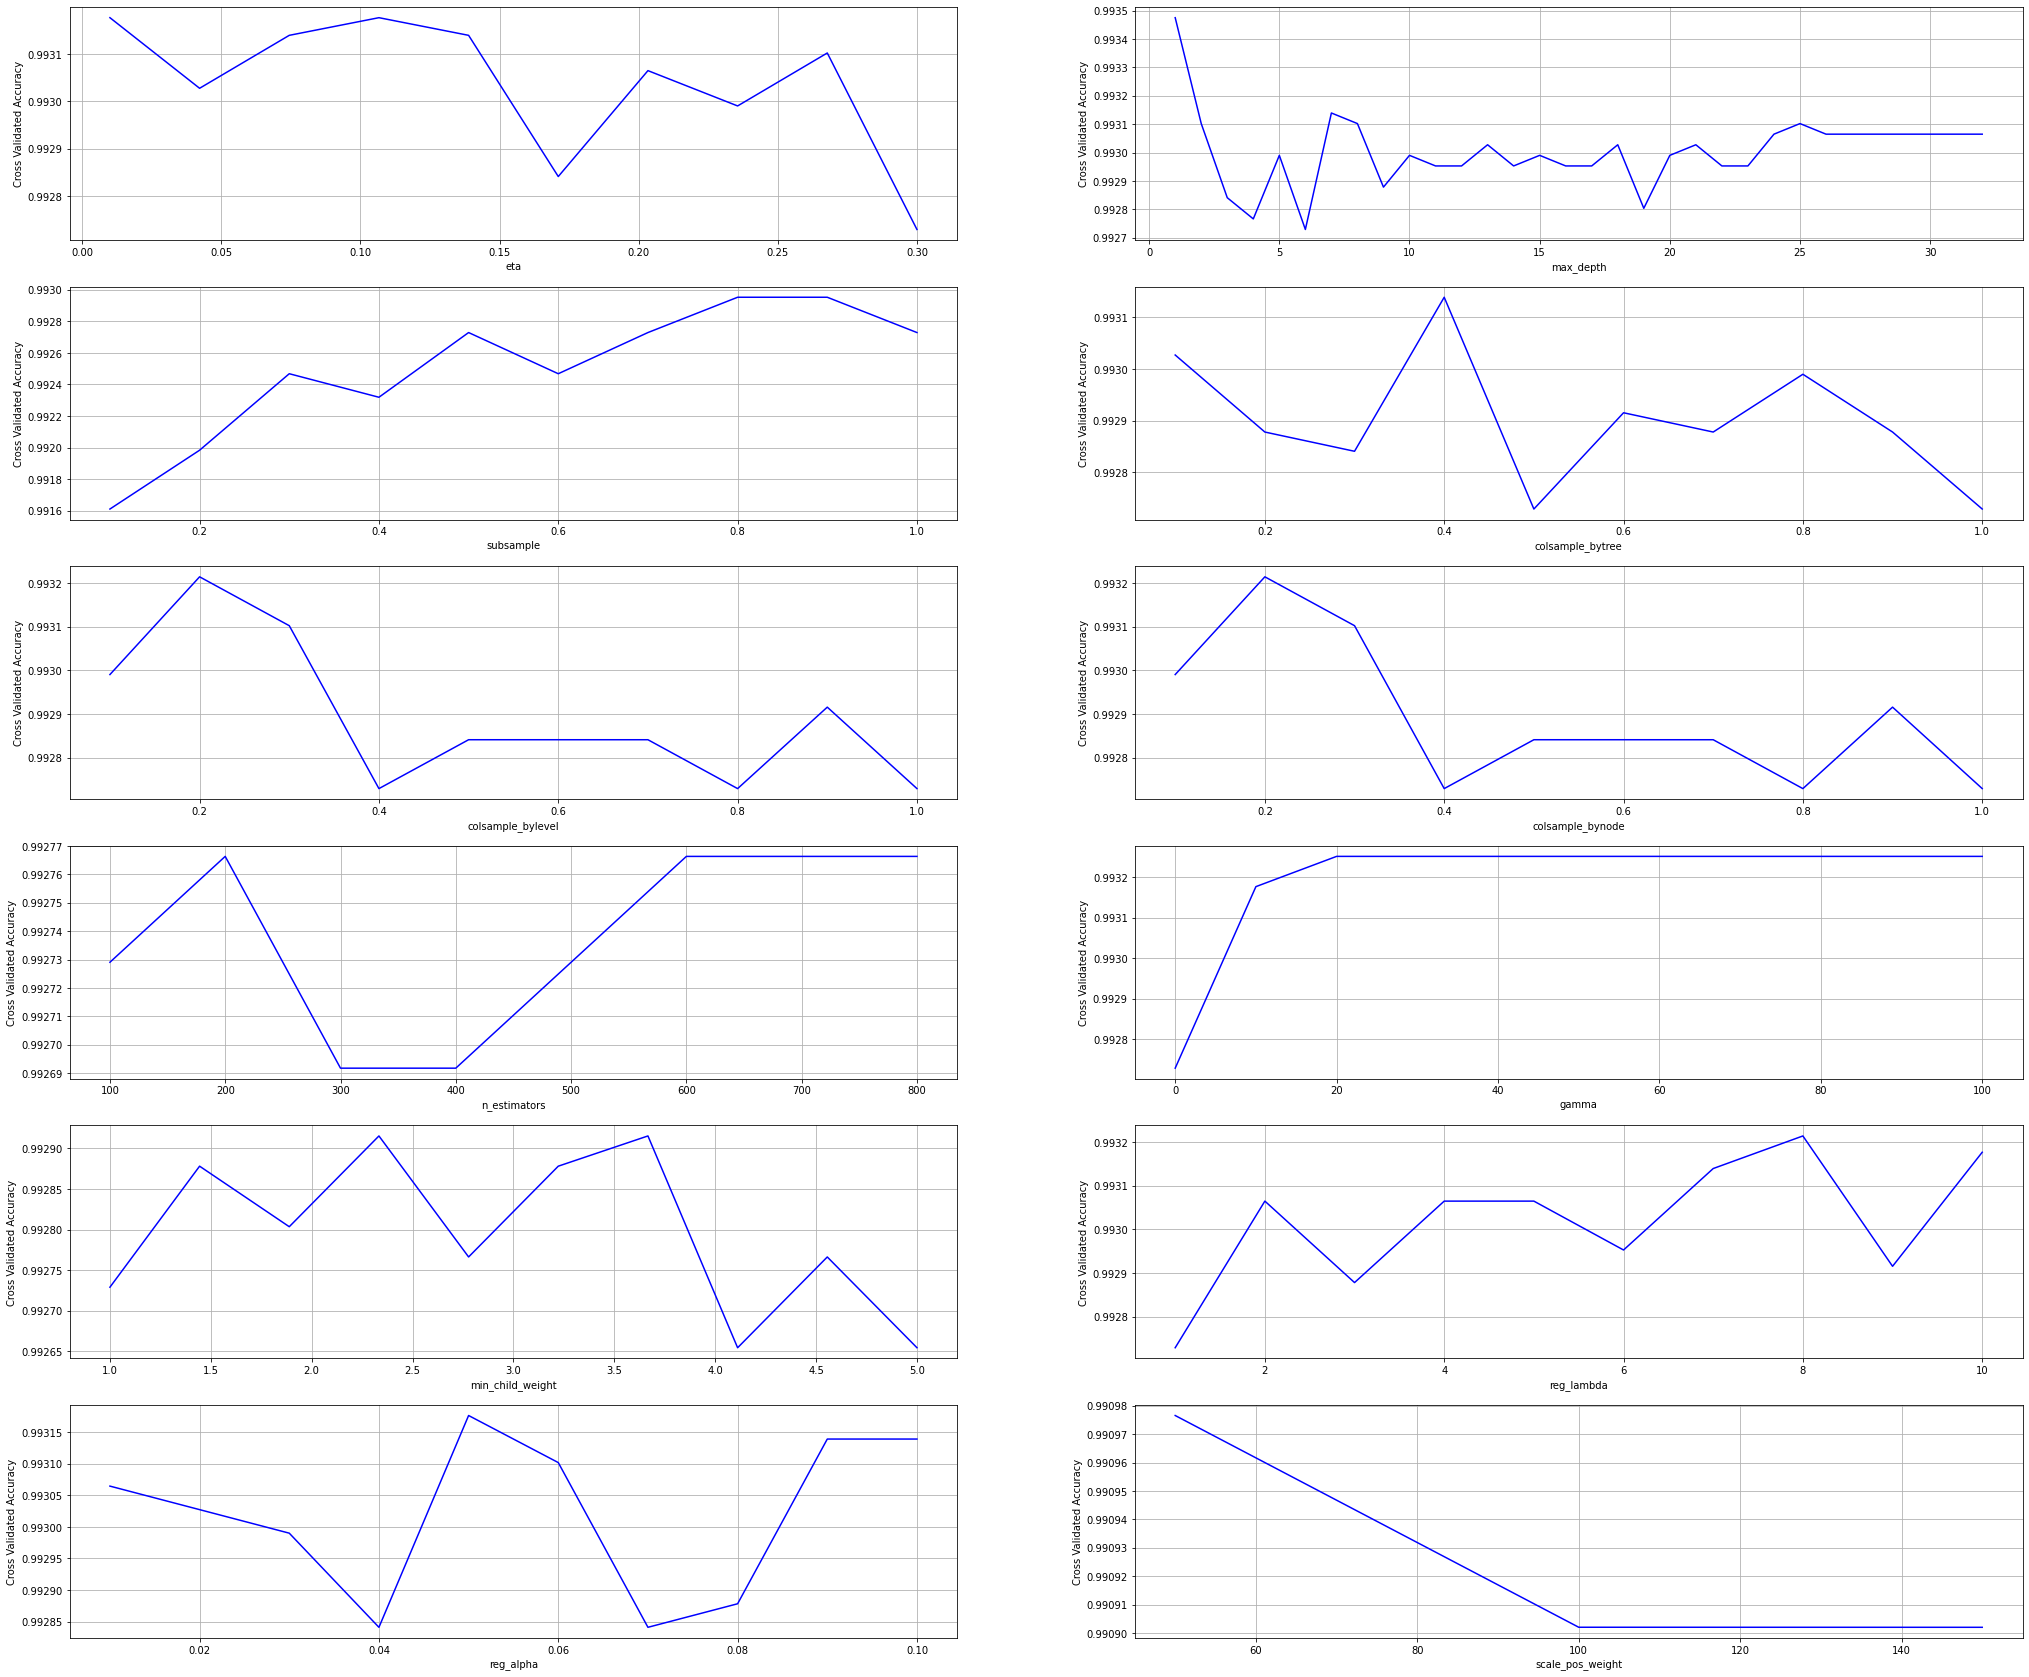

In [59]:
visualise_fold(fold_acc)

In [60]:
### ROC_AUC based metric
try:
    fold_auc = load_file('Tuning/XG_fold_roc_auc.pkl')
except:
    fold_auc = compute_fold_auc(XGBClassifier, xg_tuning_params)
    save_file('Tuning/XG_fold_roc_auc.pkl', fold_auc)

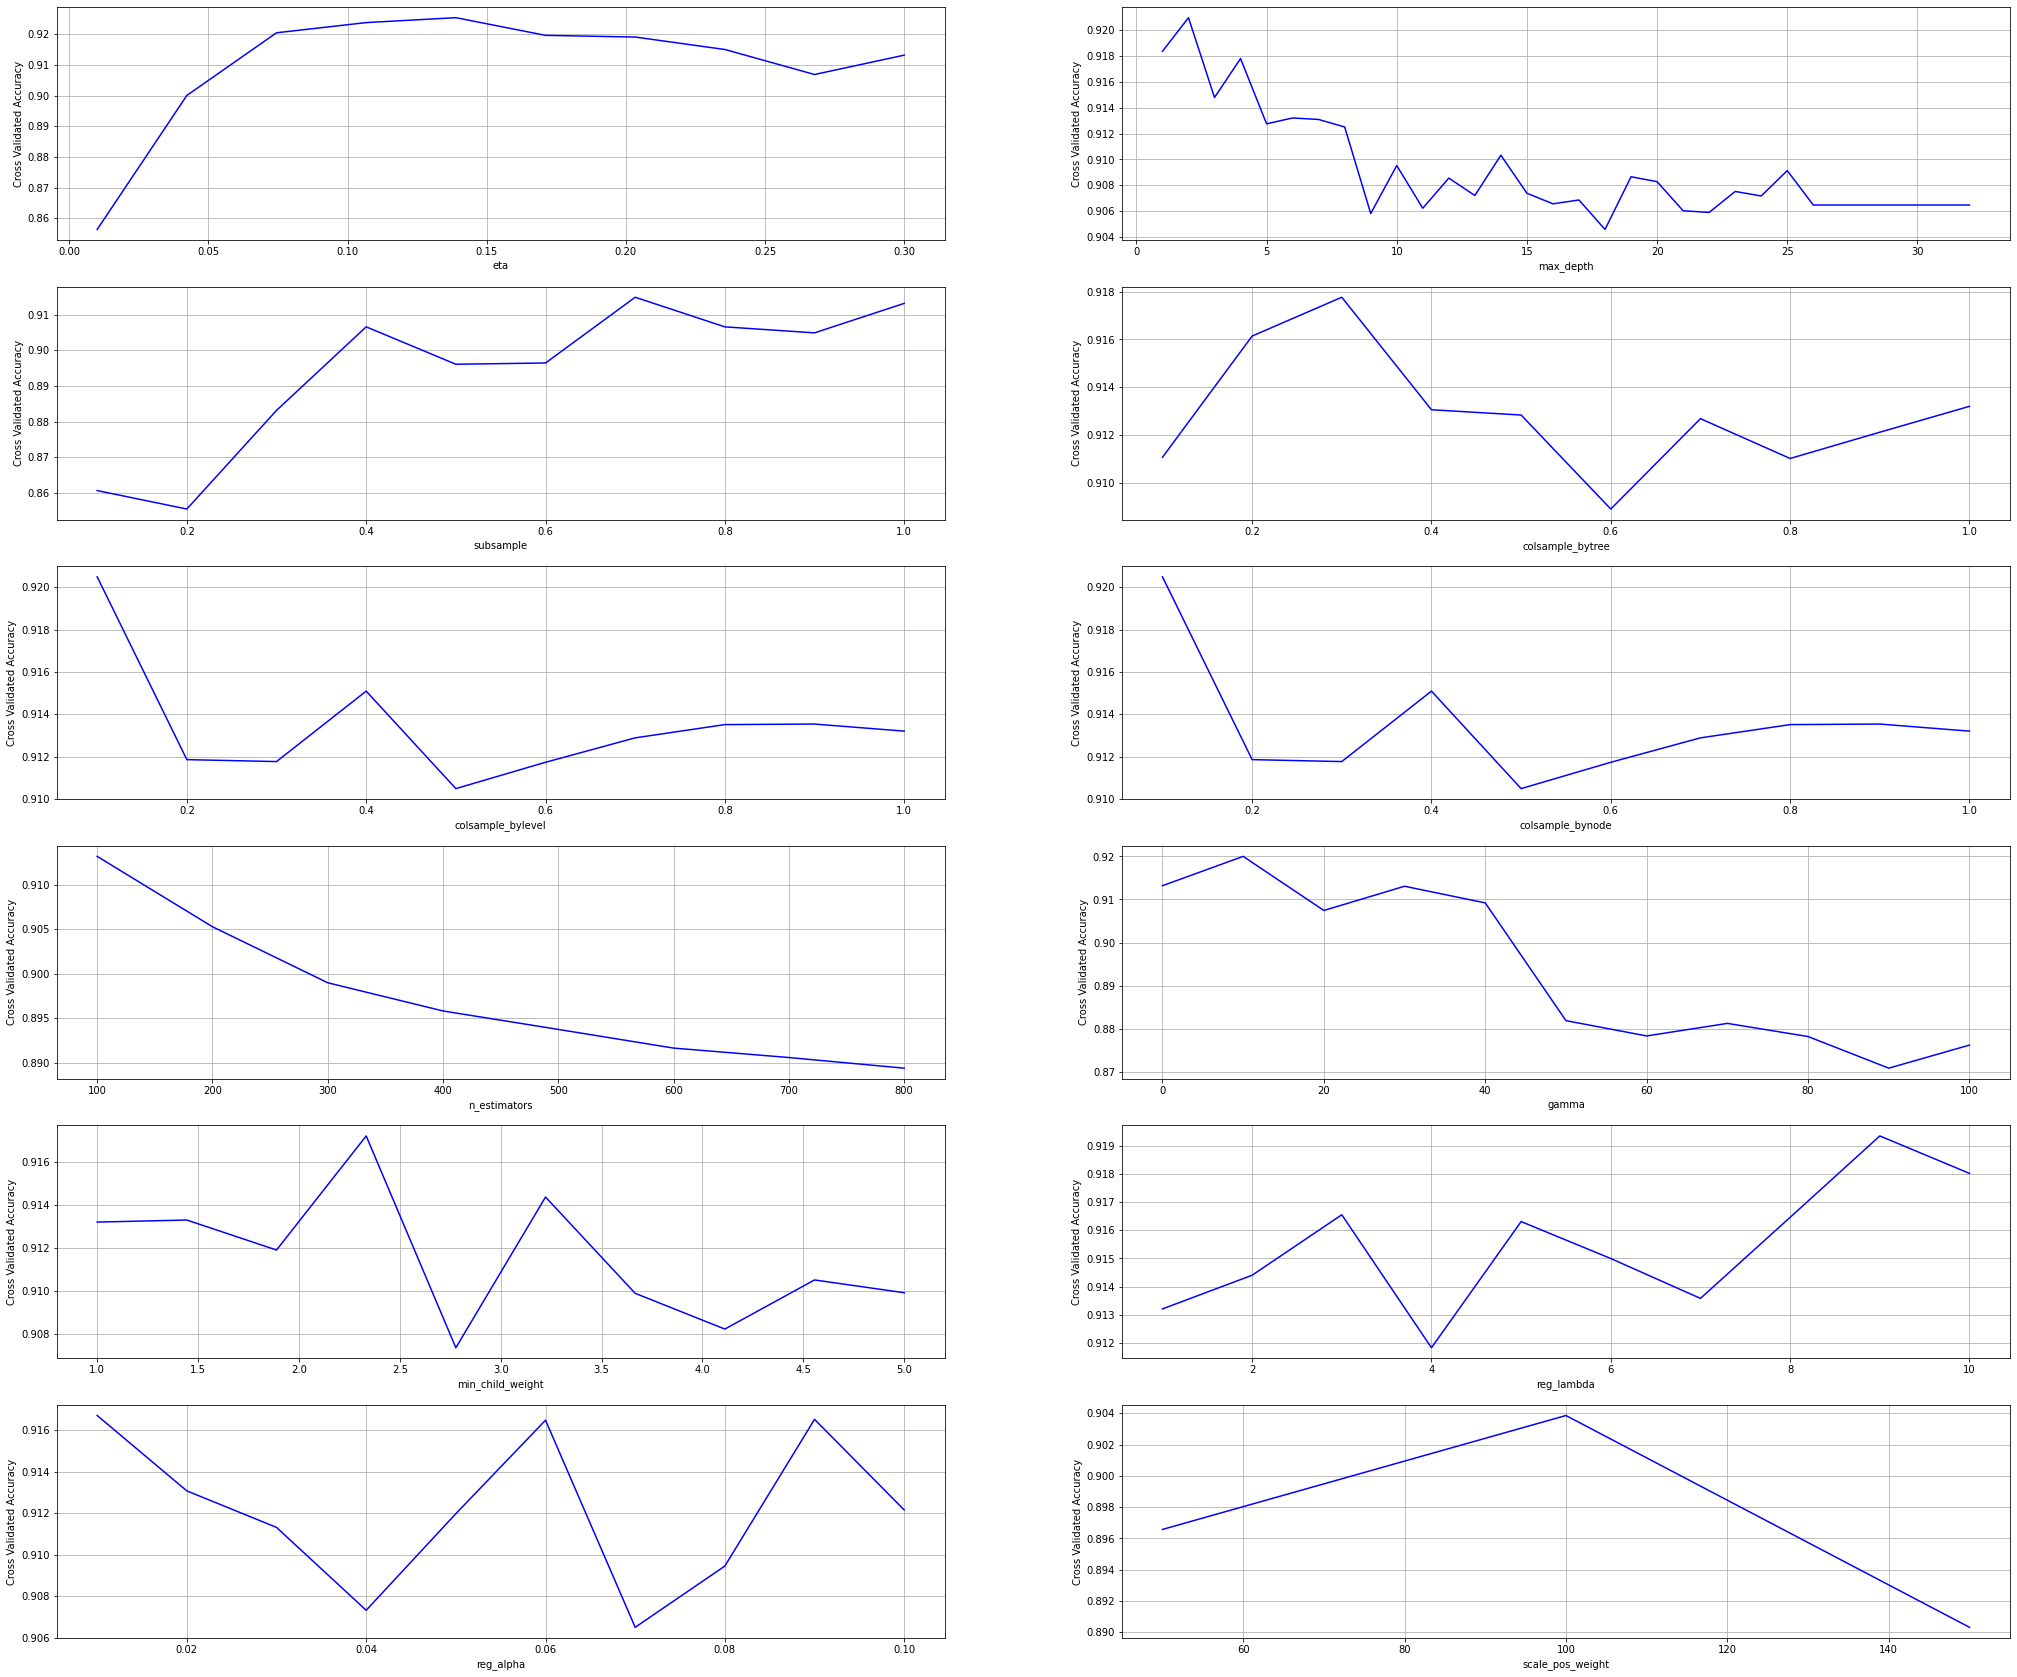

In [61]:
visualise_fold(fold_auc)

#### Perform Bayesian Hyperparameter Optimization

In [62]:
def hyperopt(param_space, X_train, y_train, num_eval, classifier, use_scaling = False):  
    start = time()
    def objective_function(params):
        clf = classifier(**params, random_state=1, scale_pos_weight=100)
        if use_scaling: clf = scale_classifier(clf)
        score = cross_val_score(clf, X_train, y_train, cv=kf, scoring='roc_auc').mean()
        return {'loss': -score, 'status': STATUS_OK}
    trials = Trials()
    best_param = fmin(objective_function, param_space, algo=tpe.suggest, max_evals=num_eval, 
                      trials=trials, rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials] 
    best_param_values = best_param
    return trials, best_param_values

In [63]:
num_eval = 100

XGB_param_hyperopt = {
    'booster': hp.choice('booster', ['gbtree', 'gblinear']), 
    'max_depth':  hp.choice('max_depth', np.arange(5, 26, 5, dtype=int)),
    'eta': hp.choice('eta', np.arange(0.1, 0.17, 0.02)),
    'subsample': hp.uniform('subsample', 0.6, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 0.4),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.3, 0.5),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.3, 0.5),
    'gamma': hp.uniform('gamma', 0, 10),
    'min_child_weight': hp.uniform('min_child_weight', 2, 2.5),
    'n_estimators': 100,
    'reg_lambda': hp.uniform('reg_lambda', 1, 9),
    'reg_alpha':hp.uniform('reg_alpha', 0.01, 0.06)
}


In [64]:
try:
    XGB_hyperopt = load_file('Tuning/XGB_hyperopt.pkl')
except:
    XGB_hyperopt = hyperopt(XGB_param_hyperopt, X_train, y_train, num_eval, xgb.XGBClassifier)
    save_file('Tuning/XGB_hyperopt.pkl', XGB_hyperopt)

In [65]:
XGB_hyperopt

(<hyperopt.base.Trials at 0x209b3556160>,
 {'booster': 0,
  'colsample_bylevel': 0.4172244489152716,
  'colsample_bynode': 0.42205200302793244,
  'colsample_bytree': 0.33464795175344825,
  'eta': 1,
  'gamma': 3.2446528293530825,
  'max_depth': 4,
  'min_child_weight': 2.364505025906861,
  'reg_alpha': 0.04149713185618908,
  'reg_lambda': 8.916340699910364,
  'subsample': 0.7953928798097403})

### Test out optimal parameters using k-fold

In [66]:
prev_optimal = XGBClassifier(random_state =1, scale_pos_weight=100, booster = "gbtree", colsample_bylevel = 0.36182410320616465,
             colsample_bynode = 0.4047432143564524, colsample_bytree =0.31605085166646796, eta=0.14,
             gamma=6.923024228104888, max_depth=20, min_child_weight=2.293462551977635, reg_alpha = 0.05274728684187166,
             reg_lambda = 8.842793806351182, subsample = 0.7548656944268172)

optimal = XGBClassifier(random_state =1, scale_pos_weight=100, booster = "gbtree", colsample_bylevel = 0.4172244489152716,
             colsample_bynode = 0.42205200302793244, colsample_bytree =0.33464795175344825, eta=0.12,
             gamma=3.2446528293530825, max_depth=25, min_child_weight=2.364505025906861, reg_alpha = 0.04149713185618908,
             reg_lambda = 8.916340699910364, subsample = 0.7953928798097403)

In [67]:
auc_scores, all_y_preds, all_y_proba, all_y_true= [], [], [], []

kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
kf.get_n_splits(train_df[x_var], train_df[y_var])

for train_index, test_index in kf.split(train_df[x_var], train_df[y_var]):
    curr_train, curr_test = train_df.iloc[train_index], train_df.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    XG = XGBClassifier(random_state =1, scale_pos_weight=100, booster = "gbtree", colsample_bylevel = 0.4172244489152716,
             colsample_bynode = 0.42205200302793244, colsample_bytree =0.33464795175344825, eta=0.12,
             gamma=3.2446528293530825, max_depth=25, min_child_weight=2.364505025906861, reg_alpha = 0.04149713185618908,
             reg_lambda = 8.916340699910364, subsample = 0.7953928798097403)
    XG.fit(X_train, y_train)
    y_preds = XG.predict(X_test)
    y_proba = XG.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

In [68]:
fpr, tpr, thresholds = roc_curve(all_y_true, all_y_preds)
print("AUC:", auc(fpr, tpr))
print("ROCAUC:", sklearn.metrics.roc_auc_score(all_y_true, all_y_preds))

print("accuracy:", accuracy_score(all_y_true, all_y_preds))

print("precision:", precision_score(all_y_true, all_y_preds))
print("recall:", recall_score(all_y_true, all_y_preds))
print("MCC:", matthews_corrcoef(all_y_true, all_y_preds))
print("F1:", f1_score(all_y_true, all_y_preds))

cm = confusion_matrix(all_y_true, all_y_preds)
TN, FP, FN, TP = cm.ravel()
print("Confusion Matrix: \n", cm)
print("True negative: %s, False positive: %s, False negative: %s, True positive: %s" %(TN, FP, FN, TP))

AUC: 0.8208243405860195
ROCAUC: 0.8208243405860195
accuracy: 0.95473358439912
precision: 0.09679937548790007
recall: 0.6850828729281768
MCC: 0.24633118411179203
F1: 0.16963064295485636
Confusion Matrix: 
 [[25481  1157]
 [   57   124]]
True negative: 25481, False positive: 1157, False negative: 57, True positive: 124


In [69]:
## Try with cross_val
X_train = train_df[x_var]
y_train = train_df[y_var]

XG = XGBClassifier(random_state =1, scale_pos_weight=100, booster = "gbtree", colsample_bylevel = 0.4172244489152716,
             colsample_bynode = 0.42205200302793244, colsample_bytree =0.33464795175344825, eta=0.12,
             gamma=3.2446528293530825, max_depth=25, min_child_weight=2.364505025906861, reg_alpha = 0.04149713185618908,
             reg_lambda = 8.916340699910364, subsample = 0.7953928798097403)

cross_val_score(XG, X_train, y_train, cv=kf, scoring='roc_auc')


array([0.92112946, 0.89423799, 0.92365282, 0.91503762, 0.93023486])

# Do again and include ALL Features (Without Feature Engineering)

### Try again with all the variables

In [110]:
x_var = ['at', 'cogs', 'csho', 'dvp', 'ebit', 'gp', 'ib', 'lct', 'lt', 'ni', 'niadj', 'oiadp', 'pi', 're', 'revt', 'sale', 
            'wcap', 'xido', 'xopr', 'mkvalt', 'sic', 'Altman_X1', 'Altman_X2', 'Altman_X3', 'Altman_X4', 'Altman_X5', 
            'Altman_z', 'sic_0', 'sic_1', 'sic_2', 'sic_3', 'sic_4', 'sic_5', 'sic_6', 'sic_7', 'sic_8', 'sic_9']

y_var = "bankrupt"


In [111]:
X_train = train_df[x_var]
y_train = train_df[y_var]

In [112]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [113]:
def compute_fold_auc(classifier, tuning_params, use_scaling=False):
    results = {}
    for feature in tqdm(tuning_params):
        accuracy = []
        for param in tuning_params[feature]:
            clf = classifier(**{feature:param}, random_state=1)
            #over here we implictly force class weight and hard-coded it here, but you may not want to do this
            if use_scaling: clf = scale_classifier(clf)
            cv_model = cross_val_score(clf, X_train, y_train, cv=kf, scoring='roc_auc', n_jobs=-1)
            accuracy.append(cv_model.mean())
        results[feature] = {
            'Accuracy':accuracy, feature: tuning_params[feature]
        }
    return results

xg_tuning_params = {
    'eta': np.linspace(0.01, 0.3, 10, endpoint=True),
    'max_depth': [i for i in range(1, 33)],
    'subsample':  np.linspace(0.1, 1.0, 10, endpoint=True),
    'colsample_bytree': np.linspace(0.1, 1.0, 10, endpoint=True),
    'colsample_bylevel': np.linspace(0.1, 1.0, 10, endpoint=True),
    'colsample_bynode': np.linspace(0.1, 1.0, 10, endpoint=True),
    'n_estimators': [i*100 for i in range(1,9)],
    'gamma':[i*10 for i in range(0,11)],
    'min_child_weight': np.linspace(1.0, 5.0, 10, endpoint=True),
    'reg_lambda': list(range(1,11)),
    'reg_alpha': np.linspace(0.01, 0.1, 10, endpoint=True),
    "scale_pos_weight": [50, 100, 150]
}

In [114]:
### ROC_AUC based metric
try:
    fold_auc = load_file('Tuning/XG_fold_roc_auc_ALLFEATURES.pkl')
except:
    fold_auc = compute_fold_auc(XGBClassifier, xg_tuning_params)
    save_file('Tuning/XG_fold_roc_auc_ALLFEATURES.pkl', fold_auc)

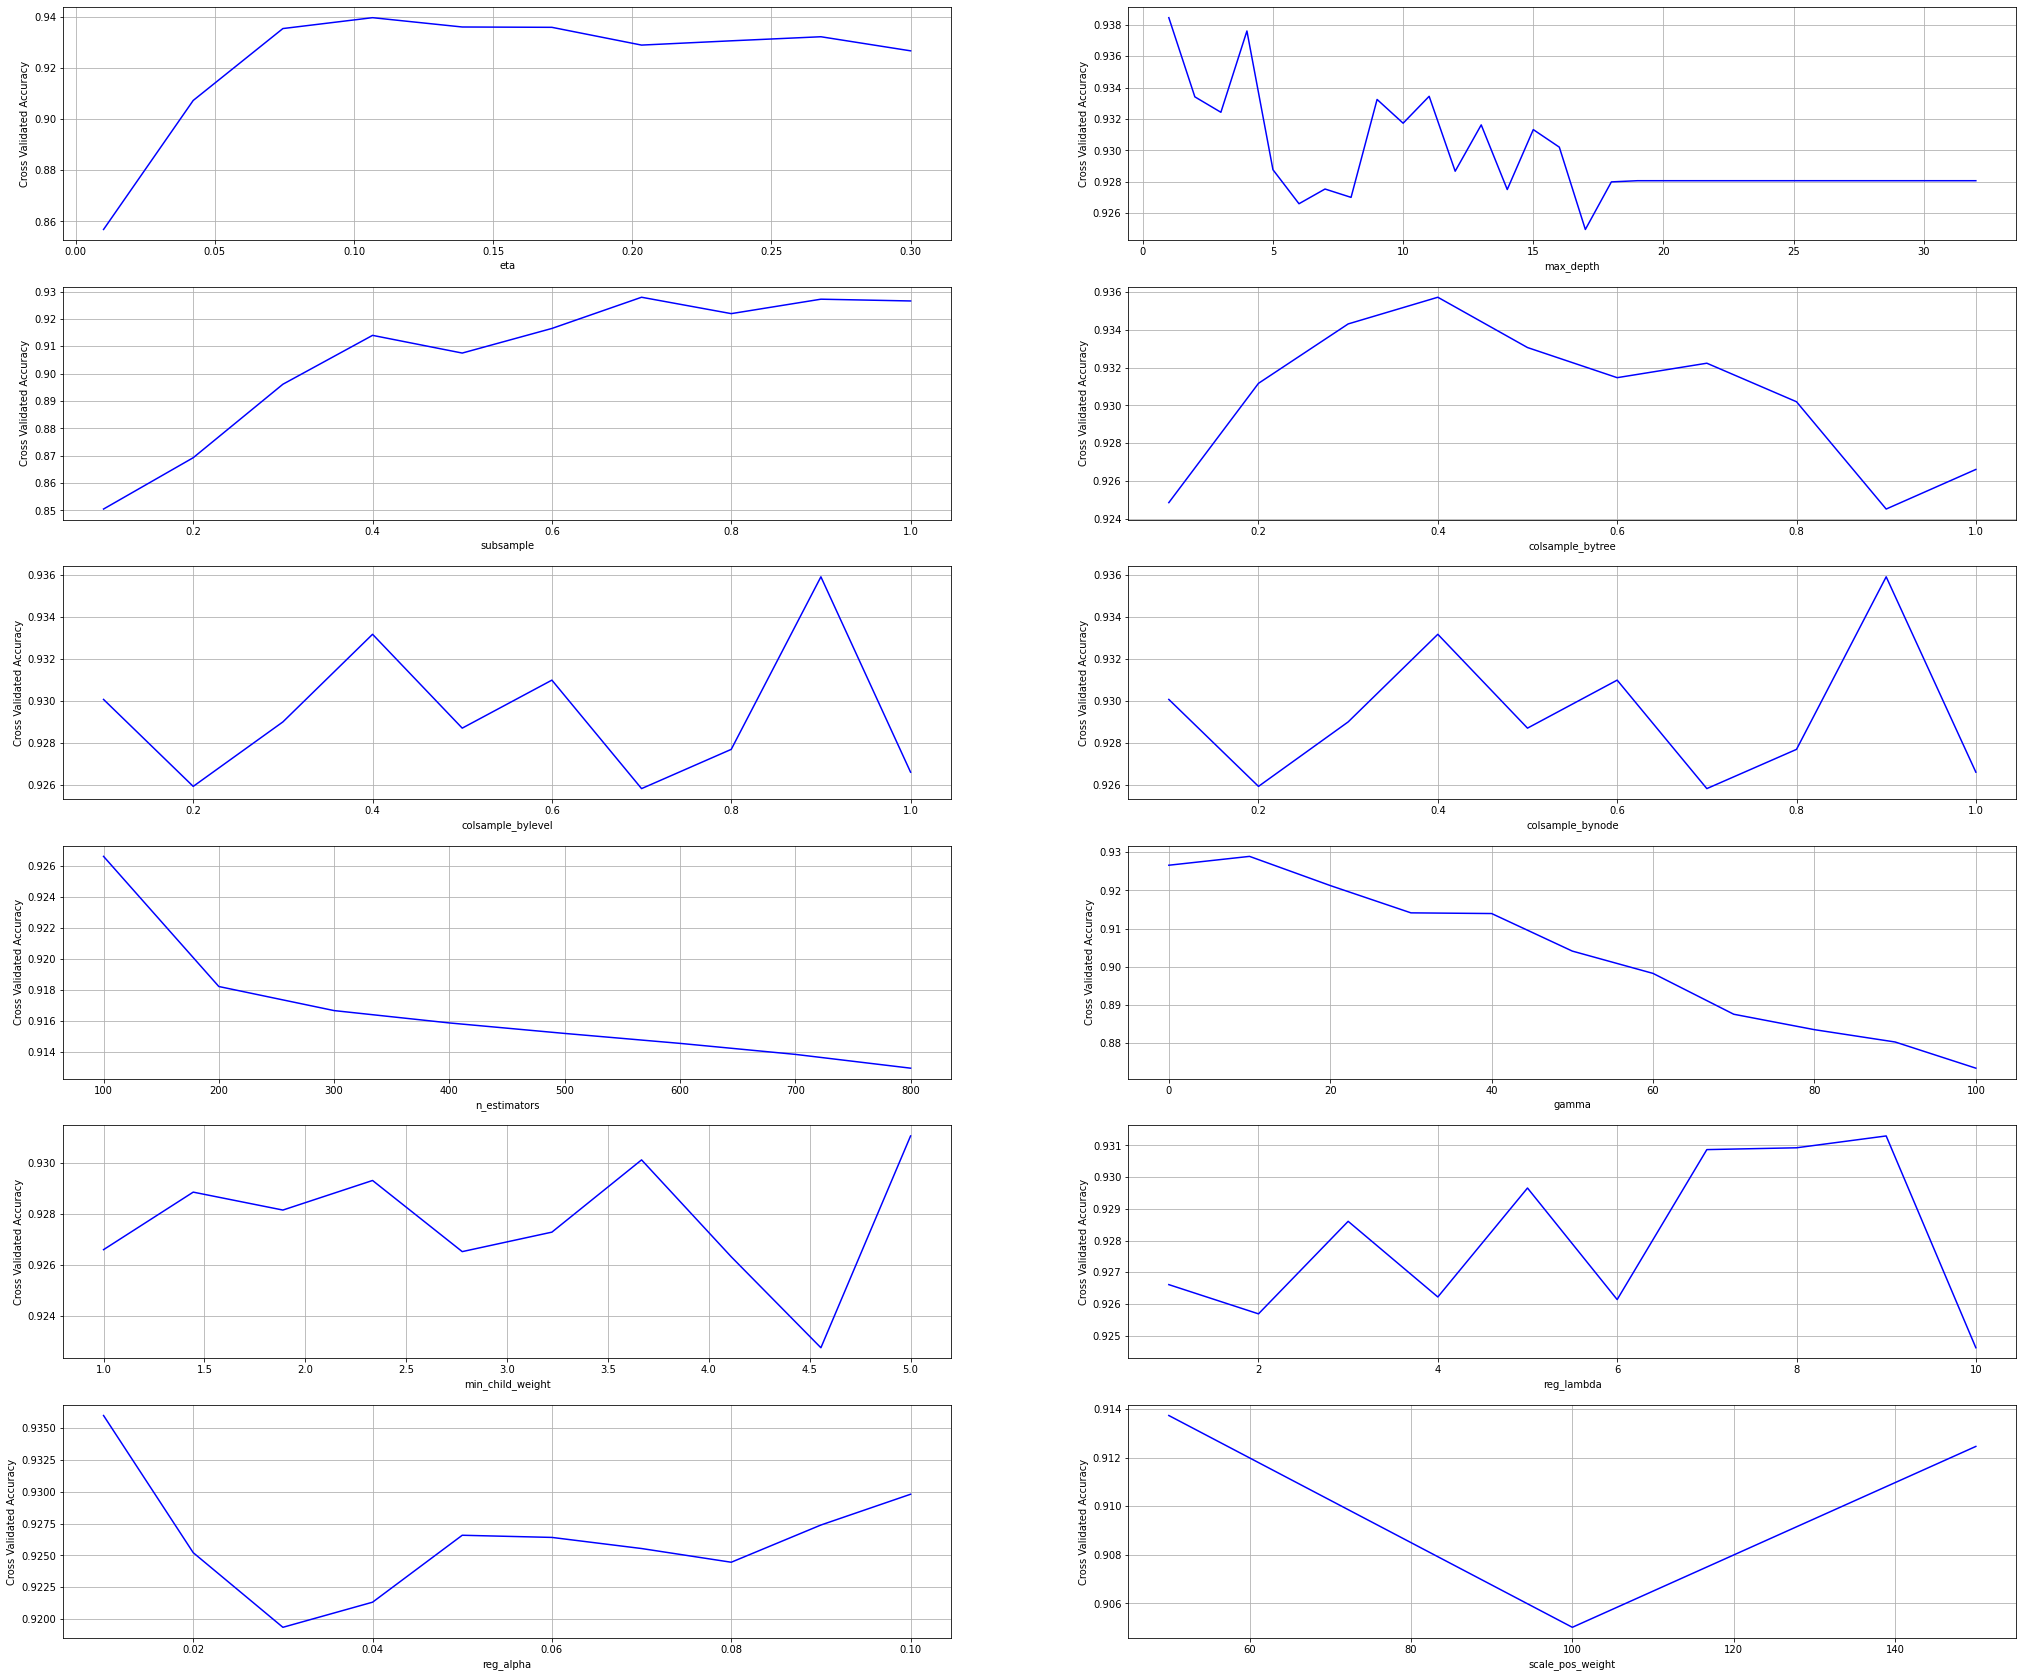

In [115]:
visualise_fold(fold_auc)

In [126]:
num_eval = 300

XGB_param_hyperopt = {
    'booster': hp.choice('booster', ['gbtree', 'gblinear']), 
    'max_depth':  hp.choice('max_depth', np.arange(5, 26, 5, dtype=int)),
    'eta': hp.choice('eta', np.arange(0.1, 0.17, 0.02)),
    'subsample': hp.uniform('subsample', 0.6, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 0.5),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.3, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.3, 1),
    'gamma': hp.uniform('gamma', 0, 10),
    'min_child_weight': hp.uniform('min_child_weight', 2, 4),
    'n_estimators': 100,
    'reg_lambda': hp.uniform('reg_lambda', 1, 9),
    'reg_alpha':hp.uniform('reg_alpha', 0.04, 0.07)
}

In [127]:
try:
    XGB_hyperopt = load_file('Tuning/XGB_hyperopt_ALLFEATURES_NOFE.pkl')
except:
    XGB_hyperopt = hyperopt(XGB_param_hyperopt, X_train, y_train, num_eval, xgb.XGBClassifier)
    save_file('Tuning/XGB_hyperopt_ALLFEATURES_NOFE.pkl', XGB_hyperopt)

[17:40:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:40:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:40:38] WARNING: C:\Users\Administrator\w

[17:41:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:41:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:41:13] WARNING: C:\Users\Administrator\w

[17:41:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:41:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:41:59] WARNING: C:\Users\Administrator\w

[17:46:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:46:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:46:03] WARNING: C:\Users\Administrator\w

[17:46:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:46:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:47:15] WARNING: C:\Users\Administrator\w

[17:48:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:48:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:48:57] WARNING: C:\Users\Administrator\w

[17:52:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:52:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:52:49] WARNING: C:\Users\Administrator\w

[17:54:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:55:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:55:41] WARNING: C:\Users\Administrator\w

[17:58:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:58:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:58:20] WARNING: C:\Users\Administrator\w

[18:01:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:01:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:02:47] WARNING: C:\Users\Administrator\w

[18:19:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:19:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:19:26] WARNING: C:\Users\Administrator\w

[18:22:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:22:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:22:49] WARNING: C:\Users\Administrator\w

[18:25:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:26:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:26:21] WARNING: C:\Users\Administrator\w

[18:29:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:18] WARNING: C:\Users\Administrator\w

[18:32:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:32:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:36:51] WARNING: C:\Users\Administrator\w

100%|██████████| 300/300 [58:33<00:00, 11.71s/trial, best loss: -0.9436380810915415]


In [128]:
XGB_hyperopt

(<hyperopt.base.Trials at 0x209a2363828>,
 {'booster': 0,
  'colsample_bylevel': 0.7892414419652471,
  'colsample_bynode': 0.9966073074430734,
  'colsample_bytree': 0.43657893234841344,
  'eta': 0,
  'gamma': 6.0654558695529595,
  'max_depth': 0,
  'min_child_weight': 2.394359666367277,
  'reg_alpha': 0.05031044278597074,
  'reg_lambda': 6.23818887071568,
  'subsample': 0.8497698018464935})

In [129]:
optimal_with_FE = XGBClassifier(random_state =1, scale_pos_weight=80, booster = "gbtree", colsample_bylevel = 0.5550296203215426,
             colsample_bynode = 0.6595307663690841, colsample_bytree = 0.4500171896021654, eta=0.1,
             gamma=5.0949358700989205, max_depth=20, min_child_weight=3.481571454347032, reg_alpha = 0.043315693602237054,
             reg_lambda = 3.4983222261451314, subsample = 0.8404391109158352)

optimal = XGBClassifier(random_state =1, scale_pos_weight=80, booster = "gbtree", colsample_bylevel = 0.7892414419652471,
             colsample_bynode = 0.9966073074430734, colsample_bytree = 0.43657893234841344, eta=0.1,
             gamma=6.0654558695529595, max_depth=20, min_child_weight=2.394359666367277, reg_alpha = 0.05031044278597074,
             reg_lambda = 6.23818887071568, subsample = 0.8497698018464935)

In [133]:
## Try with cross_val
X_train = train_df[x_var]
y_train = train_df[y_var]

XG = XGBClassifier(random_state =1, scale_pos_weight=80, booster = "gbtree", colsample_bylevel = 0.7892414419652471,
             colsample_bynode = 0.9966073074430734, colsample_bytree = 0.43657893234841344, eta=0.1,
             gamma=6.0654558695529595, max_depth=20, min_child_weight=2.394359666367277, reg_alpha = 0.05031044278597074,
             reg_lambda = 6.23818887071568, subsample = 0.8497698018464935)

cv_score = cross_val_score(XG, X_train, y_train, cv=kf, scoring='roc_auc')

In [134]:
cv_score.mean()

0.9370075387555129

### Train model on whole dataset and generate predictions on test set

In [135]:
X_train = train_df[x_var]
y_train = train_df[y_var]
X_test = test_df[x_var]

In [136]:
XG = XGBClassifier(random_state =1, scale_pos_weight=80, booster = "gbtree", colsample_bylevel = 0.7892414419652471,
             colsample_bynode = 0.9966073074430734, colsample_bytree = 0.43657893234841344, eta=0.1,
             gamma=6.0654558695529595, max_depth=20, min_child_weight=2.394359666367277, reg_alpha = 0.05031044278597074,
             reg_lambda = 6.23818887071568, subsample = 0.8497698018464935)
XG.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.7892414419652471,
              colsample_bynode=0.9966073074430734,
              colsample_bytree=0.43657893234841344, eta=0.1,
              gamma=6.0654558695529595, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.100000001,
              max_delta_step=0, max_depth=20,
              min_child_weight=2.394359666367277, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=1,
              reg_alpha=0.05031044278597074, reg_lambda=6.23818887071568,
              scale_pos_weight=80, subsample=0.8497698018464935,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [137]:
y_preds = XG.predict(X_test)
y_proba = XG.predict_proba(X_test)
y_proba

array([[9.9636608e-01, 3.6338973e-03],
       [9.9970365e-01, 2.9636259e-04],
       [9.7164005e-01, 2.8359968e-02],
       ...,
       [9.7956437e-01, 2.0435644e-02],
       [9.9891663e-01, 1.0833812e-03],
       [9.9943632e-01, 5.6368718e-04]], dtype=float32)

In [138]:
y_proba = np.array(list(map(lambda entry: entry[1], y_proba)))
y_proba

array([0.0036339 , 0.00029636, 0.02835997, ..., 0.02043564, 0.00108338,
       0.00056369], dtype=float32)

In [139]:
final_predictions = pd.DataFrame(y_proba, columns=["predict_prob"])
final_predictions.to_csv("submission_A0168820B_noFE.csv")

In [140]:
len(y_preds[y_preds == 1])

44

### Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

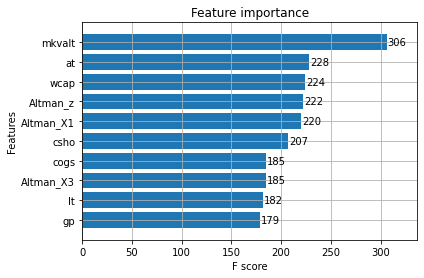

In [141]:
xgb.plot_importance(XG, max_num_features=10, height=0.8)